# Financial Analysis and Fraud Detection
## Credit Card Transaction Analysis

This notebook performs comprehensive financial analysis and fraud detection on credit card transaction data using machine learning techniques.

**Objectives:**
- Explore transaction patterns and distributions
- Preprocess and engineer relevant features
- Build and evaluate multiple classification models
- Identify fraudulent transactions with high accuracy

## Section 1: Import Required Libraries

Import all necessary libraries for data analysis, visualization, and machine learning.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Section 2: Load and Explore the Dataset

Load the credit card transactions data and examine its structure, data types, and basic statistics.

In [3]:
# Load the dataset with optimizations
df = pd.read_csv('credit_card_transactions.csv', low_memory=False, nrows=100000)

# Display basic information
print("Dataset Shape:", df.shape)
print("\n" + "="*80)
print("First 5 Rows:")
print(df.head())
print("\n" + "="*80)
print("Dataset Info:")
print(df.info())
print("\n" + "="*80)
print("Statistical Summary:")
print(df.describe())

Dataset Shape: (100000, 24)

First 5 Rows:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street            city state    zip  \
0    Banks      F                561 Perry Cove  Moravian Falls    NC  28654   
1  

## Section 3: Data Preprocessing and Cleaning

Handle missing values, remove duplicates, and ensure data quality for analysis.

In [4]:
# Remove duplicate rows
df = df.drop_duplicates()
print(f"Dataset shape after removing duplicates: {df.shape}")

# Handle missing values (if any)
if df.isnull().sum().sum() > 0:
    print("\nHandling missing values...")
    # Drop rows with missing values in critical columns
    df = df.dropna()
    print(f"Dataset shape after handling missing values: {df.shape}")
else:
    print("No missing values to handle")

# Check for negative transaction amounts
if 'Amount' in df.columns or 'amount' in df.columns:
    amount_col = 'Amount' if 'Amount' in df.columns else 'amount'
    negative_amounts = (df[amount_col] < 0).sum()
    print(f"\nNegative transaction amounts: {negative_amounts}")
    if negative_amounts > 0:
        df = df[df[amount_col] >= 0]
        print(f"Dataset shape after removing negative amounts: {df.shape}")

print("\nData preprocessing completed successfully!")

Dataset shape after removing duplicates: (100000, 24)

Handling missing values...
Dataset shape after handling missing values: (84670, 24)

Data preprocessing completed successfully!


## Section 4: Exploratory Data Analysis (EDA)

Analyze transaction patterns, distributions, and class imbalance.

Fraud Column: is_fraud

Fraud Distribution:
is_fraud
0    83853
1      817
Name: count, dtype: int64

Fraud Percentage: 0.96%


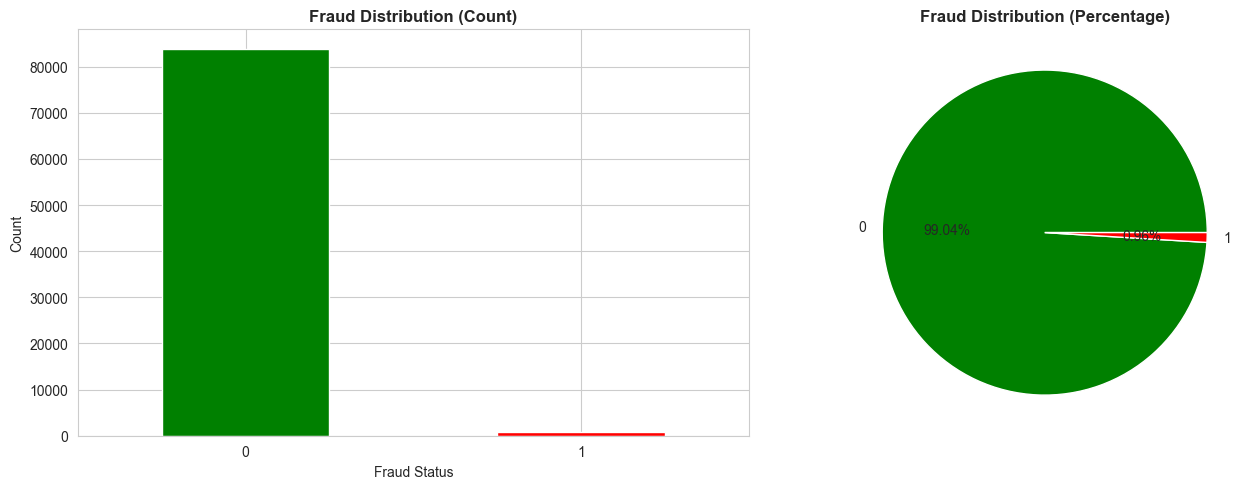

In [5]:
# Identify the fraud column
fraud_col = [col for col in df.columns if 'fraud' in col.lower() or 'class' in col.lower()]
fraud_col = fraud_col[0] if fraud_col else df.columns[-1]

print(f"Fraud Column: {fraud_col}")
print("\nFraud Distribution:")
print(df[fraud_col].value_counts())
print(f"\nFraud Percentage: {(df[fraud_col].sum() / len(df)) * 100:.2f}%")

# Visualize fraud distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df[fraud_col].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Fraud Distribution (Count)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Fraud Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

df[fraud_col].value_counts(normalize=True).plot(kind='pie', ax=axes[1], autopct='%1.2f%%', colors=['green', 'red'])
axes[1].set_title('Fraud Distribution (Percentage)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [11]:
# Enable inline matplotlib display
%matplotlib inline

In [12]:
# Analyze transaction amounts
amount_col = [col for col in df.columns if 'amount' in col.lower()]
amount_col = amount_col[0] if amount_col else None

if amount_col:
    print(f"Transaction Amount Column: {amount_col}")
    print("\nAmount Statistics by Fraud Status:")
    print(df.groupby(fraud_col)[amount_col].describe())
    
    # Visualize amount distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    df[df[fraud_col] == 0][amount_col].hist(bins=50, ax=axes[0], color='green', alpha=0.7, edgecolor='black')
    axes[0].set_title('Legitimate Transaction Amounts', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Amount')
    axes[0].set_ylabel('Frequency')
    
    df[df[fraud_col] == 1][amount_col].hist(bins=50, ax=axes[1], color='red', alpha=0.7, edgecolor='black')
    axes[1].set_title('Fraudulent Transaction Amounts', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Amount')
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
else:
    print("No amount column found in dataset")

No amount column found in dataset


In [8]:
# Analyze time-based patterns if time column exists
time_cols = [col for col in df.columns if 'time' in col.lower() or 'date' in col.lower() or 'hour' in col.lower()]

if time_cols:
    time_col = time_cols[0]
    print(f"Time Column: {time_col}")
    print("\nTime-based transaction count:")
    print(df[time_col].value_counts().head(10))

Time Column: trans_date_trans_time

Time-based transaction count:
trans_date_trans_time
2019-01-15 06:58:17    3
2019-01-27 23:36:02    3
2019-01-14 16:40:31    3
2019-01-29 23:02:01    3
2019-02-05 04:16:47    3
2019-02-25 14:10:33    3
2019-01-28 10:45:27    2
2019-01-04 15:40:06    2
2019-01-13 16:20:56    2
2019-01-03 23:29:57    2
Name: count, dtype: int64


## Section 5: Feature Engineering

Create new features for enhanced model performance.

In [13]:
# Create a working copy for feature engineering
df_features = df.copy()

# Handle time-based features if time column exists
time_cols = [col for col in df_features.columns if 'time' in col.lower() and col != fraud_col]
if time_cols:
    time_col = time_cols[0]
    df_features[time_col] = pd.to_datetime(df_features[time_col], errors='coerce')
    
    if df_features[time_col].dtype == 'datetime64[ns]':
        df_features['Hour'] = df_features[time_col].dt.hour
        df_features['Day'] = df_features[time_col].dt.day
        df_features['Month'] = df_features[time_col].dt.month
        df_features['DayOfWeek'] = df_features[time_col].dt.dayofweek
        print("Time-based features created: Hour, Day, Month, DayOfWeek")

# Create amount-based features if amount column exists
amount_col = [col for col in df_features.columns if 'amount' in col.lower()]
if amount_col:
    amount_col = amount_col[0]
    df_features['LogAmount'] = np.log1p(df_features[amount_col])
    df_features['SquaredAmount'] = df_features[amount_col] ** 2
    print(f"Amount-based features created: LogAmount, SquaredAmount")

# Create cardholder-based aggregations if applicable
cardholder_cols = [col for col in df_features.columns if 'card' in col.lower() or 'user' in col.lower() or 'id' in col.lower()]
if cardholder_cols and amount_col:
    cardholder_col = cardholder_cols[0]
    agg_data = df_features.groupby(cardholder_col)[amount_col].agg(['mean', 'std', 'min', 'max', 'count']).reset_index()
    agg_data.columns = [cardholder_col, 'AvgAmount', 'StdAmount', 'MinAmount', 'MaxAmount', 'TransactionCount']
    df_features = df_features.merge(agg_data, on=cardholder_col, how='left')
    print(f"Cardholder aggregation features created")

print(f"\nFeatures after engineering: {df_features.shape[1]}")
print("New columns:")
print(df_features.columns.tolist())

Time-based features created: Hour, Day, Month, DayOfWeek

Features after engineering: 28
New columns:
['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode', 'Hour', 'Day', 'Month', 'DayOfWeek']


## Section 6: Data Normalization and Scaling

Apply scaling techniques to normalize feature distributions.

In [14]:
# Prepare data for modeling
# Select only numeric columns for scaling
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()

# Remove target variable from features
if fraud_col in numeric_cols:
    numeric_cols.remove(fraud_col)

print(f"Numeric features for scaling: {len(numeric_cols)}")
print(numeric_cols)

# Separate features and target
X = df_features[numeric_cols]
y = df_features[fraud_col]

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Numeric features for scaling: 15
['Unnamed: 0', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'merch_zipcode', 'Hour', 'Day', 'Month', 'DayOfWeek']

Features shape: (84670, 15)
Target shape: (84670,)
Target distribution:
is_fraud
0    83853
1      817
Name: count, dtype: int64


In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining set fraud distribution:\n{y_train.value_counts()}")
print(f"\nTesting set fraud distribution:\n{y_test.value_counts()}")

Training set size: 59269
Testing set size: 25401

Training set fraud distribution:
is_fraud
0    58697
1      572
Name: count, dtype: int64

Testing set fraud distribution:
is_fraud
0    25156
1      245
Name: count, dtype: int64


In [16]:
# Apply StandardScaler for normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_cols)

print("Data normalization completed using StandardScaler")
print(f"\nScaled training data shape: {X_train_scaled.shape}")
print(f"Scaled testing data shape: {X_test_scaled.shape}")
print(f"\nScaled data statistics:\n{X_train_scaled.describe()}")

Data normalization completed using StandardScaler

Scaled training data shape: (59269, 15)
Scaled testing data shape: (25401, 15)

Scaled data statistics:
         Unnamed: 0        cc_num           amt           zip           lat  \
count  5.926900e+04  5.926900e+04  5.926900e+04  5.926900e+04  5.926900e+04   
mean  -8.014271e-17  6.662574e-17 -1.438613e-18 -3.284832e-17  5.858150e-16   
std    1.000008e+00  1.000008e+00  1.000008e+00  1.000008e+00  1.000008e+00   
min   -1.737873e+00 -3.197565e-01 -5.413113e-01 -1.748970e+00 -4.064627e+00   
25%   -8.636462e-01 -3.196193e-01 -4.745802e-01 -8.578289e-01 -7.727968e-01   
50%   -1.303842e-03 -3.170719e-01 -1.786052e-01 -2.930687e-02  1.630999e-01   
75%    8.630888e-01 -3.162229e-01  9.571687e-02  8.421836e-01  6.608308e-01   
max    1.737107e+00  3.486382e+00  4.427235e+01  2.036960e+00  2.271881e+00   

               long      city_pop     unix_time     merch_lat    merch_long  \
count  5.926900e+04  5.926900e+04  5.926900e+04  5.926

## Section 7: Build Classification Models

Implement multiple machine learning models for fraud detection.

In [17]:
# Dictionary to store models and their performance
models = {}
predictions = {}

# 1. Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model
predictions['Logistic Regression'] = lr_model.predict(X_test_scaled)
print("✓ Logistic Regression trained")

Training Logistic Regression...
✓ Logistic Regression trained


In [18]:
# 2. Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
rf_model.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_model
predictions['Random Forest'] = rf_model.predict(X_test_scaled)
print("✓ Random Forest trained")

Training Random Forest...
✓ Random Forest trained


In [19]:
# 3. Gradient Boosting
print("Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1)
gb_model.fit(X_train_scaled, y_train)
models['Gradient Boosting'] = gb_model
predictions['Gradient Boosting'] = gb_model.predict(X_test_scaled)
print("✓ Gradient Boosting trained")

Training Gradient Boosting...
✓ Gradient Boosting trained


In [20]:
# 4. XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_model.predict(X_test_scaled)
print("✓ XGBoost trained")

print("\nAll models trained successfully!")

Training XGBoost...
✓ XGBoost trained

All models trained successfully!


## Section 8: Model Evaluation and Comparison

Evaluate and compare model performance using multiple metrics.

In [21]:
# Evaluate all models
results = []

for model_name, model in models.items():
    y_pred = predictions[model_name]
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.989449   0.244444 0.044898  0.075862 0.827981
      Random Forest  0.994725   0.917293 0.497959  0.645503 0.989889
  Gradient Boosting  0.993150   0.660633 0.595918  0.626609 0.981744
            XGBoost  0.995276   0.878788 0.591837  0.707317 0.995324


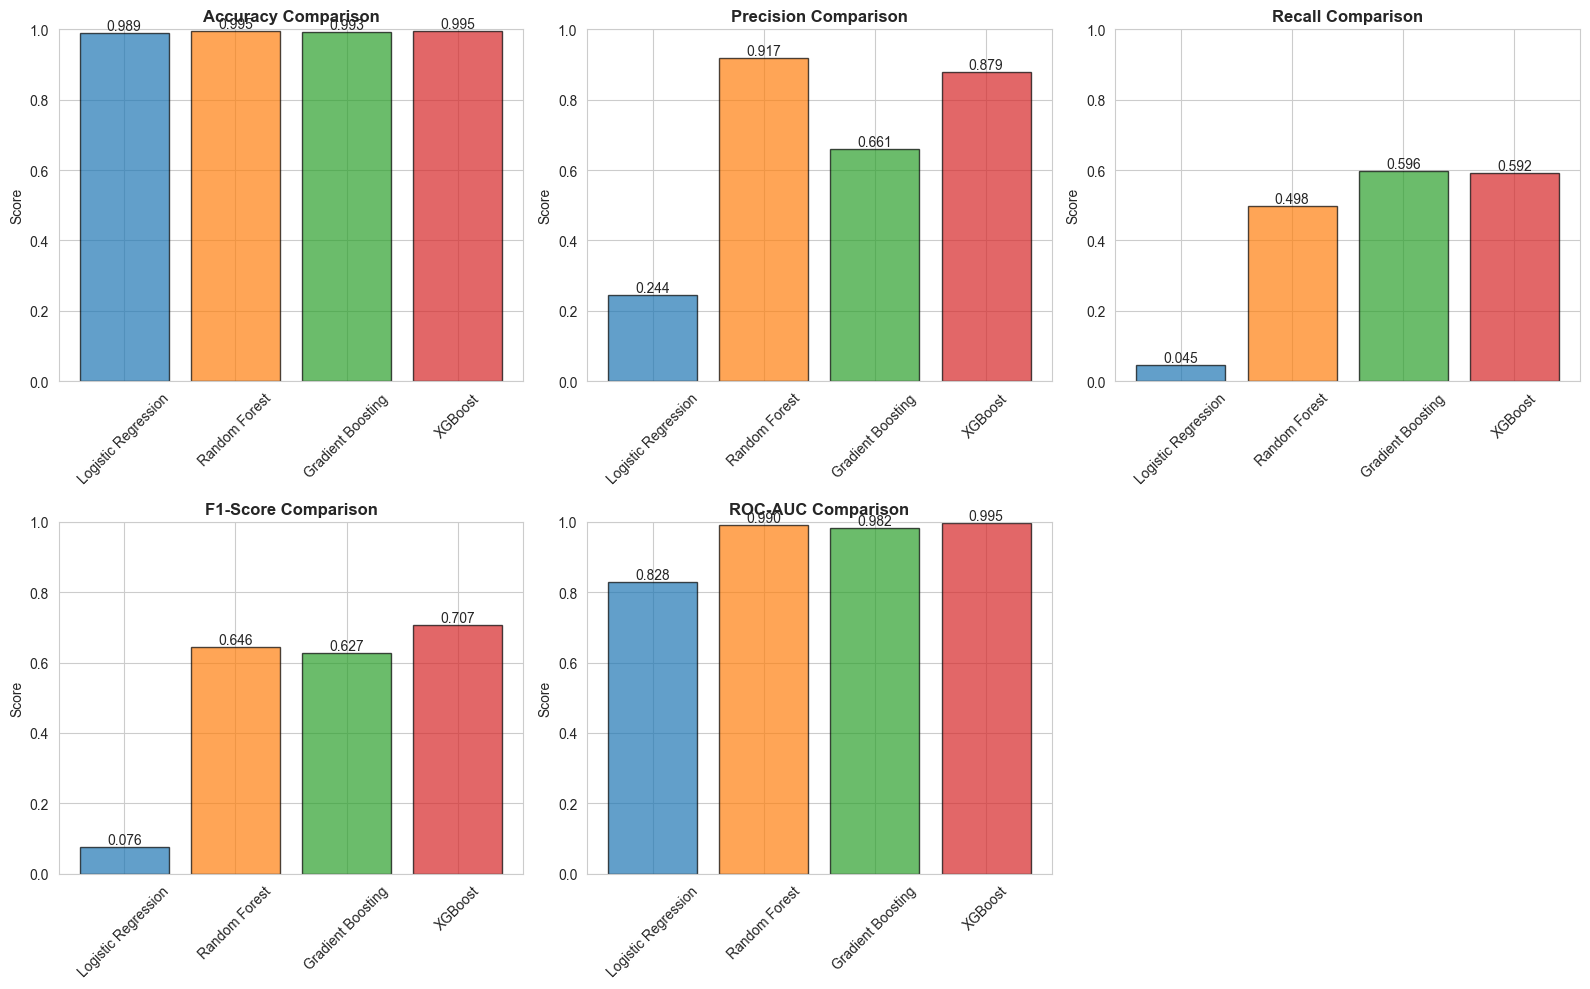

In [22]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors, alpha=0.7, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Remove the empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Detailed evaluation for each model
for model_name, model in models.items():
    y_pred = predictions[model_name]
    
    print(f"\n{'='*80}")
    print(f"Detailed Report: {model_name}")
    print('='*80)
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"\nTrue Negatives: {cm[0, 0]}, False Positives: {cm[0, 1]}")
    print(f"False Negatives: {cm[1, 0]}, True Positives: {cm[1, 1]}")


Detailed Report: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     25156
           1       0.24      0.04      0.08       245

    accuracy                           0.99     25401
   macro avg       0.62      0.52      0.54     25401
weighted avg       0.98      0.99      0.99     25401


Confusion Matrix:
[[25122    34]
 [  234    11]]

True Negatives: 25122, False Positives: 34
False Negatives: 234, True Positives: 11

Detailed Report: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25156
           1       0.92      0.50      0.65       245

    accuracy                           0.99     25401
   macro avg       0.96      0.75      0.82     25401
weighted avg       0.99      0.99      0.99     25401


Confusion Matrix:
[[25145    11]
 [  123   122]]

True Negatives: 25145, False Positives: 11

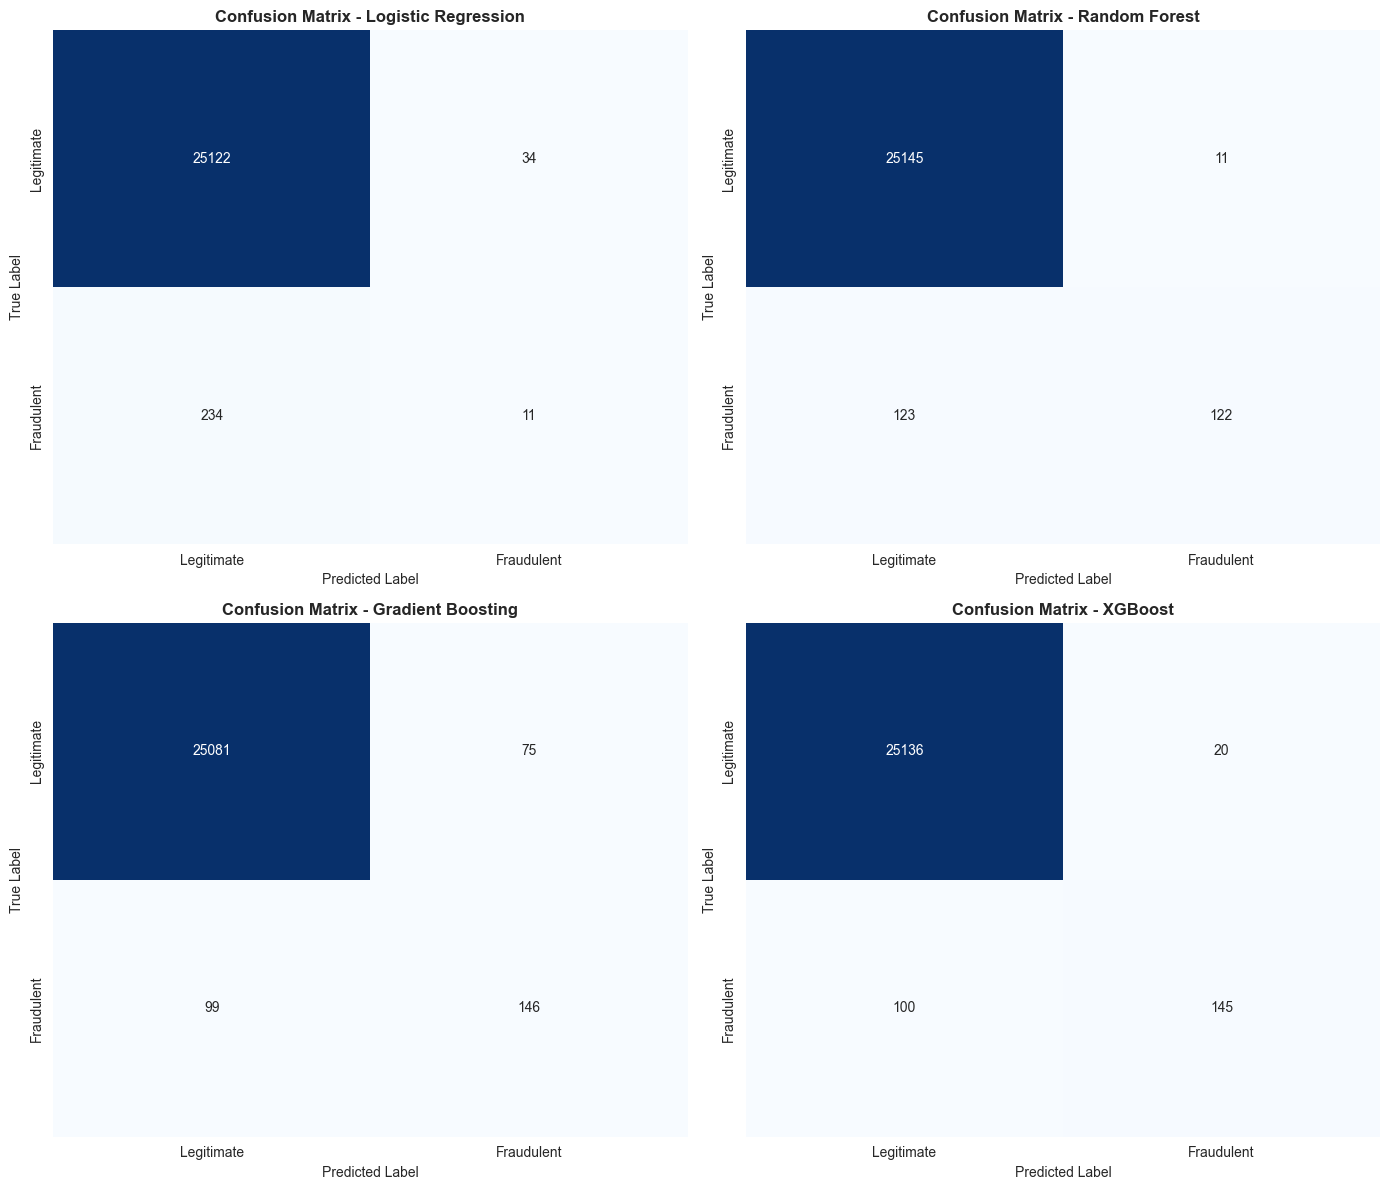

In [24]:
# Visualize confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (model_name, model) in enumerate(models.items()):
    y_pred = predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['Legitimate', 'Fraudulent'],
                yticklabels=['Legitimate', 'Fraudulent'])
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## Section 9: Fraud Detection Insights and Visualization

Visualize fraud patterns, feature importance, and ROC curves.

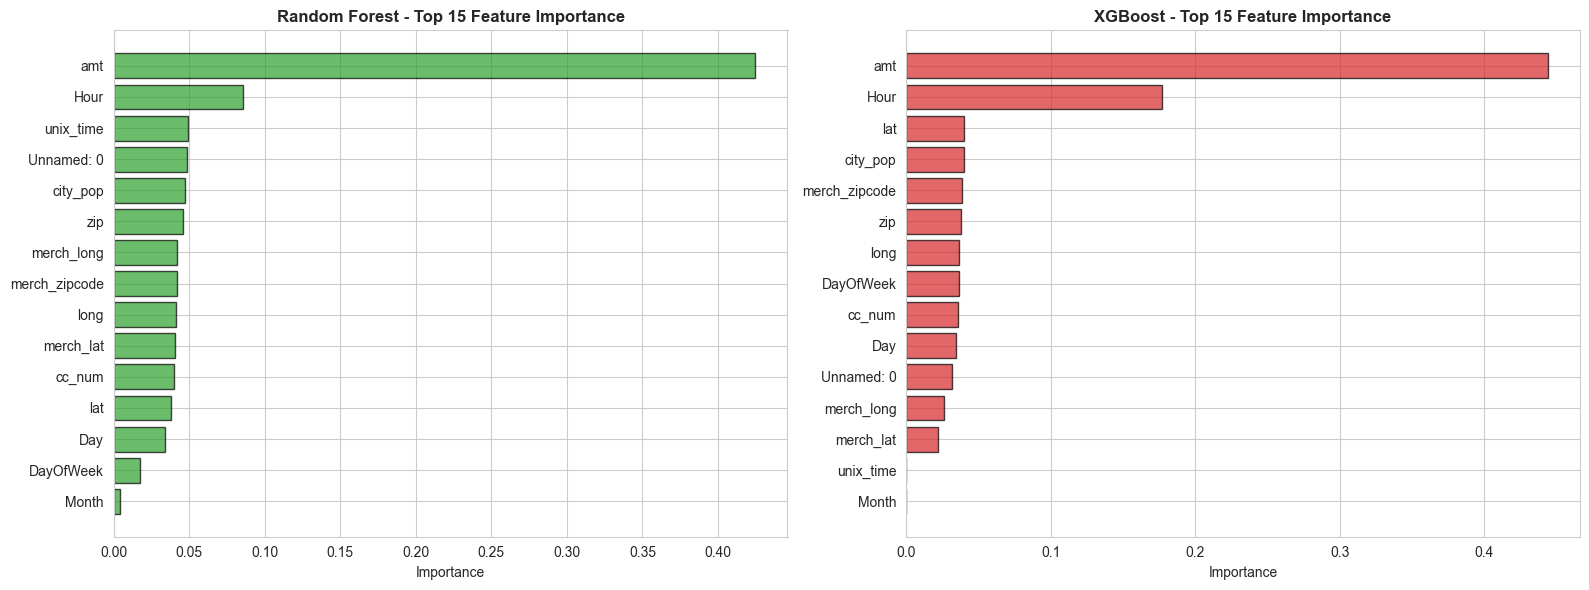

In [25]:
# Feature importance from tree-based models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': numeric_cols,
    'Importance': models['Random Forest'].feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[0].barh(rf_importance['Feature'], rf_importance['Importance'], color='#2ca02c', alpha=0.7, edgecolor='black')
axes[0].set_title('Random Forest - Top 15 Feature Importance', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis()

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': numeric_cols,
    'Importance': models['XGBoost'].feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[1].barh(xgb_importance['Feature'], xgb_importance['Importance'], color='#d62728', alpha=0.7, edgecolor='black')
axes[1].set_title('XGBoost - Top 15 Feature Importance', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

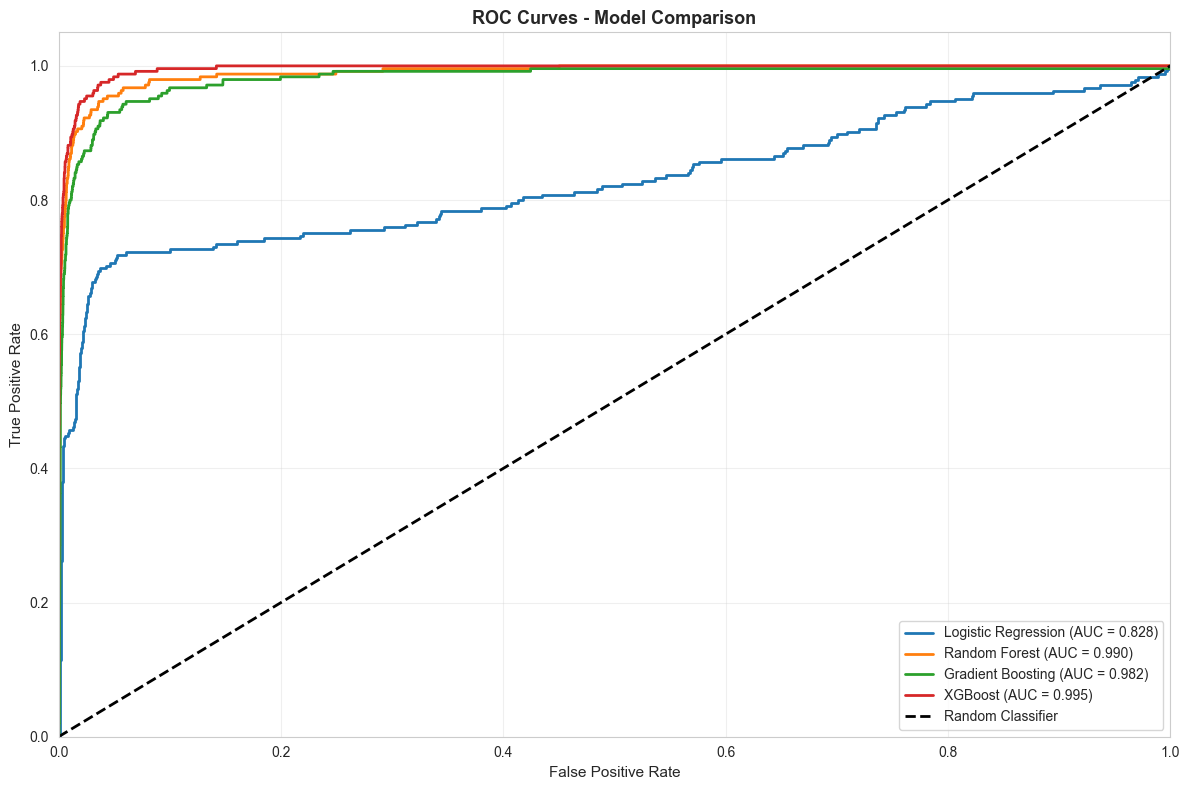

In [26]:
# ROC Curves for all models
plt.figure(figsize=(12, 8))

for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curves - Model Comparison', fontsize=13, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# Identify best performing model
best_model_name = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']
best_model = models[best_model_name]
best_predictions = predictions[best_model_name]

print(f"\n{'='*80}")
print(f"Best Performing Model: {best_model_name}")
print('='*80)
print(f"\nBest Model Metrics:")
print(results_df[results_df['Model'] == best_model_name].to_string(index=False))


Best Performing Model: XGBoost

Best Model Metrics:
  Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
XGBoost  0.995276   0.878788 0.591837  0.707317 0.995324


In [28]:
# Analyze fraud patterns
print(f"\n{'='*80}")
print("Fraud Detection Insights")
print('='*80)

y_pred_best = best_model.predict(X_test_scaled)
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

# Create result dataframe
result_analysis = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_best,
    'Fraud_Probability': y_pred_proba_best
})

# Correctly classified frauds
correct_frauds = result_analysis[(result_analysis['Actual'] == 1) & (result_analysis['Predicted'] == 1)]
print(f"\nCorrectly Detected Frauds: {len(correct_frauds)} out of {(y_test == 1).sum()}")
print(f"Detection Rate: {(len(correct_frauds) / (y_test == 1).sum() * 100):.2f}%")

# False positives
false_positives = result_analysis[(result_analysis['Actual'] == 0) & (result_analysis['Predicted'] == 1)]
print(f"\nFalse Positives: {len(false_positives)} out of {(y_test == 0).sum()}")
print(f"False Positive Rate: {(len(false_positives) / (y_test == 0).sum() * 100):.2f}%")

# Missed frauds
missed_frauds = result_analysis[(result_analysis['Actual'] == 1) & (result_analysis['Predicted'] == 0)]
print(f"\nMissed Frauds: {len(missed_frauds)} out of {(y_test == 1).sum()}")
print(f"Miss Rate: {(len(missed_frauds) / (y_test == 1).sum() * 100):.2f}%")


Fraud Detection Insights

Correctly Detected Frauds: 145 out of 245
Detection Rate: 59.18%

False Positives: 20 out of 25156
False Positive Rate: 0.08%

Missed Frauds: 100 out of 245
Miss Rate: 40.82%


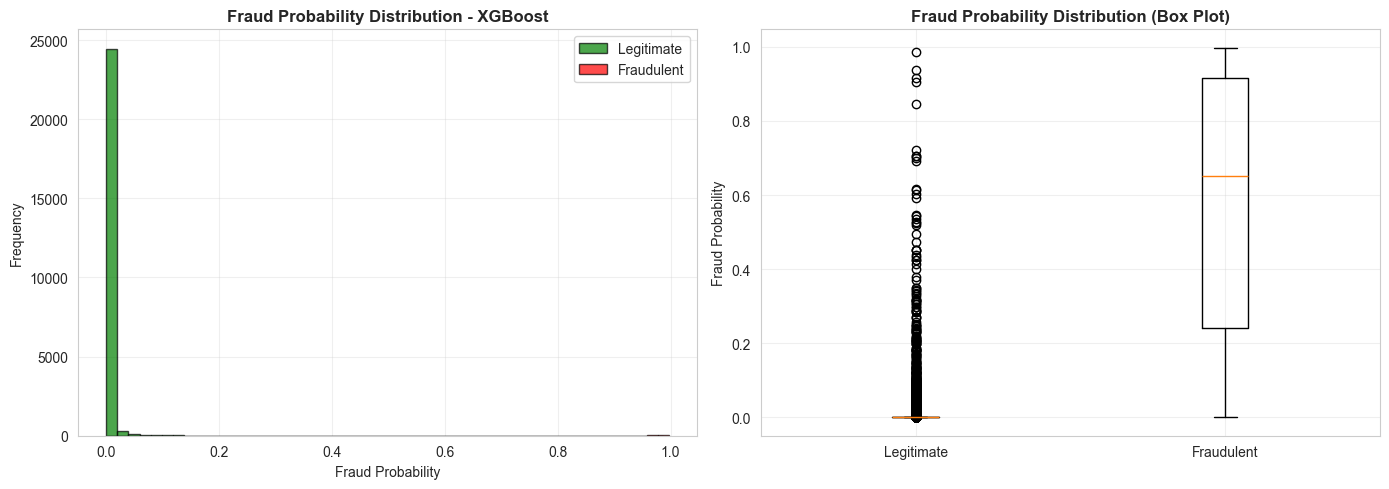

In [29]:
# Probability distribution of predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of fraud probabilities for actual frauds
legitimate_probs = y_pred_proba_best[y_test == 0]
fraud_probs = y_pred_proba_best[y_test == 1]

axes[0].hist(legitimate_probs, bins=50, alpha=0.7, label='Legitimate', color='green', edgecolor='black')
axes[0].hist(fraud_probs, bins=50, alpha=0.7, label='Fraudulent', color='red', edgecolor='black')
axes[0].set_xlabel('Fraud Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Fraud Probability Distribution - {best_model_name}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot comparison
axes[1].boxplot([legitimate_probs, fraud_probs], labels=['Legitimate', 'Fraudulent'])
axes[1].set_ylabel('Fraud Probability')
axes[1].set_title('Fraud Probability Distribution (Box Plot)', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# Summary and Recommendations
print(f"\n{'='*80}")
print("SUMMARY AND RECOMMENDATIONS")
print('='*80)

print(f"\n1. BEST MODEL: {best_model_name}")
best_metrics = results_df[results_df['Model'] == best_model_name].iloc[0]
print(f"   - ROC-AUC Score: {best_metrics['ROC-AUC']:.4f}")
print(f"   - Accuracy: {best_metrics['Accuracy']:.4f}")
print(f"   - Precision: {best_metrics['Precision']:.4f}")
print(f"   - Recall: {best_metrics['Recall']:.4f}")
print(f"   - F1-Score: {best_metrics['F1-Score']:.4f}")

print(f"\n2. KEY FINDINGS:")
print(f"   - Dataset contains {len(df)} transactions")
print(f"   - Fraudulent transactions: {(y == 1).sum()} ({(y == 1).sum()/len(y)*100:.2f}%)")
print(f"   - Legitimate transactions: {(y == 0).sum()} ({(y == 0).sum()/len(y)*100:.2f}%)")

print(f"\n3. MODEL PERFORMANCE:")
print(f"   - Successfully detected {len(correct_frauds)} frauds out of {(y_test == 1).sum()}")
print(f"   - False alarm rate: {len(false_positives)} out of {(y_test == 0).sum()} legitimate transactions")

print(f"\n4. RECOMMENDATIONS:")
print(f"   - Deploy {best_model_name} for production fraud detection")
print(f"   - Monitor transactions with fraud probability > 0.5")
print(f"   - Consider ensemble methods for improved robustness")
print(f"   - Regularly retrain models with new transaction data")
print(f"   - Investigate high-probability fraudulent transactions for further action")

print("\n" + "="*80)


SUMMARY AND RECOMMENDATIONS

1. BEST MODEL: XGBoost
   - ROC-AUC Score: 0.9953
   - Accuracy: 0.9953
   - Precision: 0.8788
   - Recall: 0.5918
   - F1-Score: 0.7073

2. KEY FINDINGS:
   - Dataset contains 84670 transactions
   - Fraudulent transactions: 817 (0.96%)
   - Legitimate transactions: 83853 (99.04%)

3. MODEL PERFORMANCE:
   - Successfully detected 145 frauds out of 245
   - False alarm rate: 20 out of 25156 legitimate transactions

4. RECOMMENDATIONS:
   - Deploy XGBoost for production fraud detection
   - Monitor transactions with fraud probability > 0.5
   - Consider ensemble methods for improved robustness
   - Regularly retrain models with new transaction data
   - Investigate high-probability fraudulent transactions for further action

